In [1]:
import os
directory = '../../output.demo'
database= "gtdb-genus-n0.protein-k11-scaled100" #,gtdb-genus-n0.nucleotide-k21-scaled1000,gtdb-genus-n0.dayhoff-k19-scaled100"
render='svg'
name="demo"

In [2]:
# NTP: this is currently just a port from Charcoal, not useful as-is. fix/extend!

In [3]:
from thumper.charcoal_utils import CSV_DictHelper
from IPython.display import display, Markdown

summary = CSV_DictHelper(f'{directory}/classify/{name}.x.{database}.taxonomy-report.csv', 'genome')
display(Markdown(f"# taxonomic summary report for `{name}.x.{database}`"))

# taxonomic summary report for `demo.x.gtdb-genus-n0.protein-k11-scaled100`

In [4]:
import plotly.graph_objects as go
from thumper import charcoal_utils as utils
import collections
import os

In [5]:
# calculate and display some basic statistics
#summary = utils.CSV_DictHelper(f'{directory}/genome_summary.csv', 'genome')
summary = utils.CSV_DictHelper(f'{directory}/classify/{name}.x.{database}.taxonomy-report.csv', 'genome')

all_genomes = set(summary)

n_genomes = len(all_genomes)
no_lineage = set([ k for k in all_genomes if not summary[k].lineage ])
n_no_lineage = len(no_lineage)
all_genomes -= no_lineage

no_genus_contam = set([ k for k in all_genomes if int(summary[k].genus_bad_bp) == 0 ])
n_no_contam = len(no_genus_contam)
all_genomes -= no_genus_contam
contaminated_list = set(all_genomes)
clean_list = set(no_genus_contam)

#needs_lineage = [ k for k in no_lineage if int(summary[k].needs_lineage_flag) ]
#n_needs_lineage = len(needs_lineage)

first_contam = {}
ignore = set()

for rank in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
    n = 0
    for genome in all_genomes:
        bad_bp = int(summary[genome][f'{rank}_bad_bp'])
        if genome in ignore:
            continue
        if bad_bp:
            n += 1
            ignore.add(genome)
            continue
    first_contam[rank] = n
    
def display_genome_list(names_to_show, order_by=None, reverse=True):
    # select only those we want to show
    values = [ summary[k] for k in names_to_show ]
    
    # sort by:
    if order_by:
        values.sort(key=lambda x: int(x[order_by]))
        if reverse: values.reverse()
    else:
        values.sort(key = lambda x: x.genome)
    
    output = []
    for row in values:
        output.append(f"* [`{row.genome}`]({row.genome}.fig.html)")
    
    return "\n".join(output)

def display_no_lineage_list():
    values = [ summary[k] for k in summary if not summary[k].lineage ]
    
    x = []
    for row in values:
        x.append(f"* `{row.genome}` - {row.comment}")
        
    return "\n".join(x)

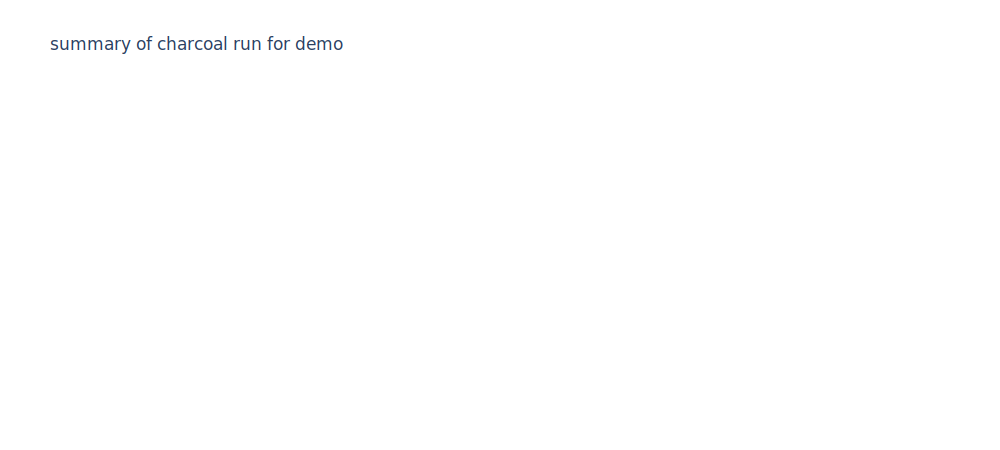

In [6]:
labels = ["all genomes", "all analyzed", "contaminated", "no contamination", "not analyzed", "no matches"] #, "needs lineage"]
parents = [ "", "all genomes", "all analyzed", "all analyzed", "all genomes", "not analyzed", "not analyzed"]

# get basic numbers in --
values = [ len(summary),
           len(summary) - n_no_lineage,
           len(contaminated_list),
           n_no_contam,
           n_no_lineage,
           #n_no_lineage - n_needs_lineage,
           #n_needs_lineage,
           ]

# add per-rank breakdown
for rank in reversed(['superkingdom', 'phylum', 'class', 'order', 'family', 'genus']):
    labels.append(rank)
    parents.append('contaminated')
    values.append(first_contam[rank])
    
# display!

fig = go.Figure(go.Treemap(
    branchvalues = "total",
    labels = labels,
    parents = parents,
    values = values,
    textinfo = "label+value+percent entry",
    outsidetextfont = {"size": 20, "color": "darkblue"},
    marker = {"line": {"width": 2}},
    pathbar = {"visible": False}))

fig.update_layout(treemapcolorway = ["lavenderblush", "lightblue"],
                  title=f'summary of charcoal run for {name}')
fig.show(render, width=1000)

In [7]:
###### do display

display(Markdown(f"""
# Summary statistics

charcoal examined {n_genomes} total genomes in `{name}`.

{n_no_lineage} could not be analyzed for contamination; see Problem Report, below.

{n_no_contam} had no observed contamination at any taxonomic level down to genus.

Of the remaining {len(contaminated_list)} genomes,
* {first_contam['superkingdom']} had their first observed contamination at **superkingdom**;
* {first_contam['phylum']} had their first observed contamination at **phylum**;
* {first_contam['class']} had their first observed contamination at **class**;
* {first_contam['order']} had their first observed contamination at **order**;
* {first_contam['family']} had their first observed contamination at **family**;
* {first_contam['genus']} had their first observed contamination at **genus**.
"""))


# Summary statistics

charcoal examined 2 total genomes in `demo`.

0 could not be analyzed for contamination; see Problem Report, below.

0 had no observed contamination at any taxonomic level down to genus.

Of the remaining 2 genomes,
* 0 had their first observed contamination at **superkingdom**;
* 0 had their first observed contamination at **phylum**;
* 0 had their first observed contamination at **class**;
* 1 had their first observed contamination at **order**;
* 0 had their first observed contamination at **family**;
* 1 had their first observed contamination at **genus**.


In [8]:

def make_hitlist_data(hit_list_filename, omit_genus=True, num=10):
    hits = utils.CSV_DictHelper(hit_list_filename, 'genome')
    
    endings = '.fna.gz', 'fa.gz', '.fa', '_genomic'
    
    # sort by sum of bad bp at specific rank
    if omit_genus:
        sort_by = 'family_bad_bp'
    else:
        sort_by = 'genus_bad_bp'
    
    # pick off the top num items, sorted by given sort_by
    items = list(hits.rows.items())
    items.sort(key=lambda item: -int(item[1][sort_by]))
    items = items[:num]
    items.reverse()
    
    hitlist_data = collections.defaultdict(list)
    names = hitlist_data['names']
    
    # for each item, retrieve all tax rank bp values
    for name, row in items:
        # clean up names:
        for end in endings:
            if name.endswith(end): name = name[:-len(end)]
        names.append(name)

        last_bp = 0
        for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
            bp = row[f'{key}_bad_bp']
            bp = int(bp)
            values = hitlist_data[key]
            values.append(bp - last_bp)
            last_bp = bp
            
    return hitlist_data

def plot_hitlist(hit_list_filename, omit_genus=True, num=10):
    hitlist_data = make_hitlist_data(hit_list_filename, omit_genus, num)
    
    names = hitlist_data['names']

    barchart_objs = []
    for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
        values = hitlist_data[key]
        if omit_genus and key == 'genus': break
            
        bc_obj = go.Bar(name=key, y=names, x=values, orientation='h')
        barchart_objs.append(bc_obj)
        
    fig = go.Figure(data=barchart_objs)
    title = f'top genome contamination by taxonomic rank: {os.path.dirname(hit_list_filename)[7:]}'
    fig.update_layout(barmode='stack', template='plotly',
                      xaxis_title='Estimated contamination by rank',
                      title=title)

    return fig

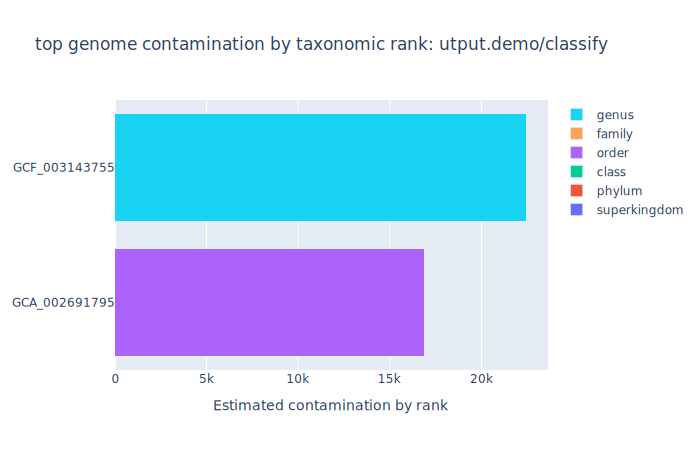

In [9]:
fig = plot_hitlist(f'{directory}/classify/{name}.x.{database}.taxonomy-report.csv', omit_genus=False)

if not render: render_name = None
else: render_name = render
fig.show(render_name)

In [10]:

display(Markdown(f"""
## Individual contamination reports

(Sorted by summed contamination at genus level.)

{display_genome_list(contaminated_list, 'genus_bad_bp')}

## Problem Report

{n_no_lineage} genomes could not be analyzed for contamination.

{display_no_lineage_list()}

## Analyzed genomes for which no removable contamination was detected

{n_no_contam} genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)

{display_genome_list(clean_list)}

"""))


## Individual contamination reports

(Sorted by summed contamination at genus level.)

* [`GCF_003143755`](GCF_003143755.fig.html)
* [`GCA_002691795`](GCA_002691795.fig.html)

## Problem Report

0 genomes could not be analyzed for contamination.



## Analyzed genomes for which no removable contamination was detected

0 genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)



